In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time
import dill
import pandas as pd
import plotly.express as ply_exp
import plotly.graph_objects as ply_go

# Configurando o acesso do tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada

# gpus = tf.config.experimental.list_physical_devices('GPU') # Listando as placas de vídeo
# tf.config.experimental.set_memory_growth(gpus[0], True)    # Selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

In [3]:
nomes = [
    "WENO-JS"     , "WENO-Z"      , "WENO-Z+"     , 
    "WENO-JS (M)" , "WENO-Z (M)"  , "WENO-Z+ (M)" , 
    "WENO-JS (MS)", "WENO-Z (MS)" , "WENO-Z+ (MS)", 
    "WENO-JS (BI)", "WENO-Z (BI)" , "WENO-Z+ (BI)",
    "WENO-ZC (M)" , "WENO-ZC (MS)", "WENO-ZC (BI)"
]

API      = API_Numpy
equation = transp_equation

WENOs = {}
WENOs[nomes[ 0]] = simulation(API, equation, WENO_JS, mapping =     null_mapping, map_function = None).Sim
WENOs[nomes[ 1]] = simulation(API, equation, WENO_Z , mapping =     null_mapping, map_function = None).Sim
WENOs[nomes[ 2]] = simulation(API, equation, WENO_Zp, mapping =     null_mapping, map_function = None).Sim
WENOs[nomes[ 3]] = simulation(API, equation, WENO_JS, mapping =     post_mapping, map_function = Henrick_mapping).Sim
WENOs[nomes[ 4]] = simulation(API, equation, WENO_Z , mapping =     post_mapping, map_function = Henrick_mapping).Sim
WENOs[nomes[ 5]] = simulation(API, equation, WENO_Zp, mapping =     post_mapping, map_function = Henrick_mapping).Sim
WENOs[nomes[ 6]] = simulation(API, equation, WENO_JS, mapping =      pre_mapping, map_function = Hong_mapping).Sim
WENOs[nomes[ 7]] = simulation(API, equation, WENO_Z , mapping =      pre_mapping, map_function = Hong_mapping).Sim
WENOs[nomes[ 8]] = simulation(API, equation, WENO_Zp, mapping =      pre_mapping, map_function = Hong_mapping).Sim
WENOs[nomes[ 9]] = simulation(API, equation, WENO_JS, mapping =      pre_mapping, map_function = BI_mapping).Sim
WENOs[nomes[10]] = simulation(API, equation, WENO_Z , mapping =      pre_mapping, map_function = BI_mapping).Sim
WENOs[nomes[11]] = simulation(API, equation, WENO_Zp, mapping =      pre_mapping, map_function = BI_mapping).Sim
WENOs[nomes[12]] = simulation(API, equation, WENO_ZC, mapping = post_inv_mapping, map_function = Henrick_mapping).Sim
WENOs[nomes[13]] = simulation(API, equation, WENO_ZC, mapping =  pre_inv_mapping, map_function = Hong_mapping).Sim
WENOs[nomes[14]] = simulation(API, equation, WENO_ZC, mapping =  pre_inv_mapping, map_function = BI_mapping).Sim

In [4]:
def teste_ADR(N, phi):
    
    f = lambda x, phi: np.exp(1j*x*phi)
    x = np.arange(N, dtype = float_pres)
    
    return f(x, phi)

In [47]:
N   = 100
Δx  = 1/N
τ   = 10**(-2)
CFL = 1

fronteira = FronteiraPeriodica

ADR = {}
for nome in nomes:
    
    Phi = np.zeros(int(N/2)+1, dtype="complex64")
    for n in np.arange(int(N/2)+1):
        
        phi    = 2*np.pi*n/N
        u      = teste_ADR(N, phi)
        u_hat  = WENOs[nome](u, τ, Δx, CFL, fronteira)
        v      = np.matmul(u_hat, np.exp(-1j*np.arange(N)*phi))/N
        
        Phi[n] = 1j*(Δx/τ)*np.log(v)
    
    ADR[nome] = Phi
    print(nome)

WENO-JS
WENO-Z
WENO-Z+
WENO-JS (M)
WENO-Z (M)
WENO-Z+ (M)
WENO-JS (MS)
WENO-Z (MS)
WENO-Z+ (MS)
WENO-JS (BI)
WENO-Z (BI)
WENO-Z+ (BI)
WENO-ZC (M)
WENO-ZC (MS)
WENO-ZC (BI)


In [52]:
x     = 2*np.pi*np.arange(int(N/2)+1)/N
y     = np.real(ADR[nomes[0]])
label = tf.repeat([nomes[0]], [int(N/2)+1])

for i in range(1, len(nomes)):
    x = tf.concat([x, 2*np.pi*np.arange(int(N/2)+1)/N], axis = 0)
    y = tf.concat([y, np.real(ADR[nomes[i]])], axis = 0)
    label = tf.concat([label, tf.repeat([nomes[i]], [int(N/2)+1])], axis = 0)

df = pd.DataFrame(
    {
        "x"     : x     ,
        "y"     : y     ,
        "label" : label
    }
)

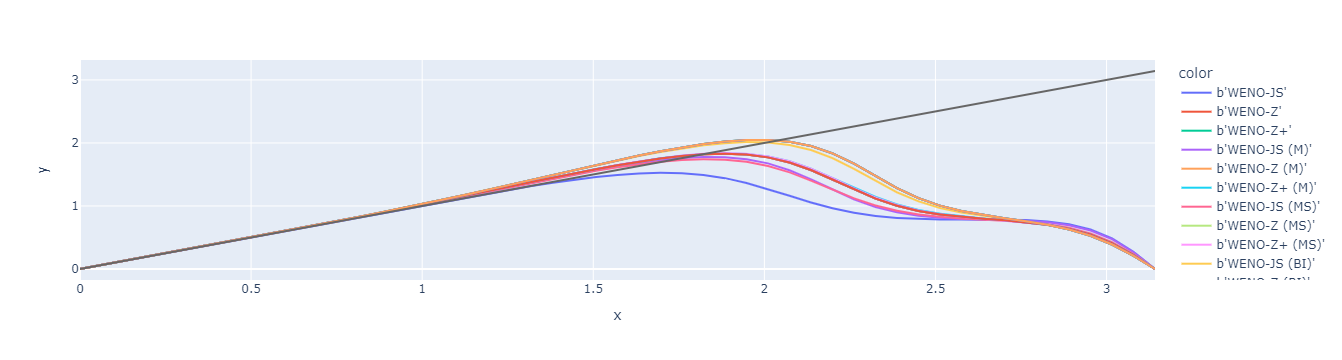

In [53]:
fig = ply_exp.line(
    data_frame = df    ,
    x          = x     ,
    y          = y     ,
    color      = label
)
fig.add_trace(
    ply_go.Scatter(
        x    = 2*np.pi*np.arange(int(N/2)+1)/N,
        y    = 2*np.pi*np.arange(int(N/2)+1)/N,
        mode = "lines"                                           ,
        line = ply_go.scatter.Line(color="#666666")              ,
        name = "Referência"
    )
)
fig.show()

In [54]:
fig.write_html("C:/Users/daniw/OneDrive/Documentos/GitHub/Top_mat_A/WENO-BI/teste_ADR_real (N=100, tau=10^(-2)).html")

In [55]:
x     = 2*np.pi*np.arange(int(N/2)+1)/N
y     = np.imag(ADR[nomes[0]])
label = tf.repeat([nomes[0]], [int(N/2)+1])

for i in range(1, len(nomes)):
    x = tf.concat([x, 2*np.pi*np.arange(int(N/2)+1)/N], axis = 0)
    y = tf.concat([y, np.imag(ADR[nomes[i]])], axis = 0)
    label = tf.concat([label, tf.repeat([nomes[i]], [int(N/2)+1])], axis = 0)

df = pd.DataFrame(
    {
        "x"     : x     ,
        "y"     : y     ,
        "label" : label
    }
)

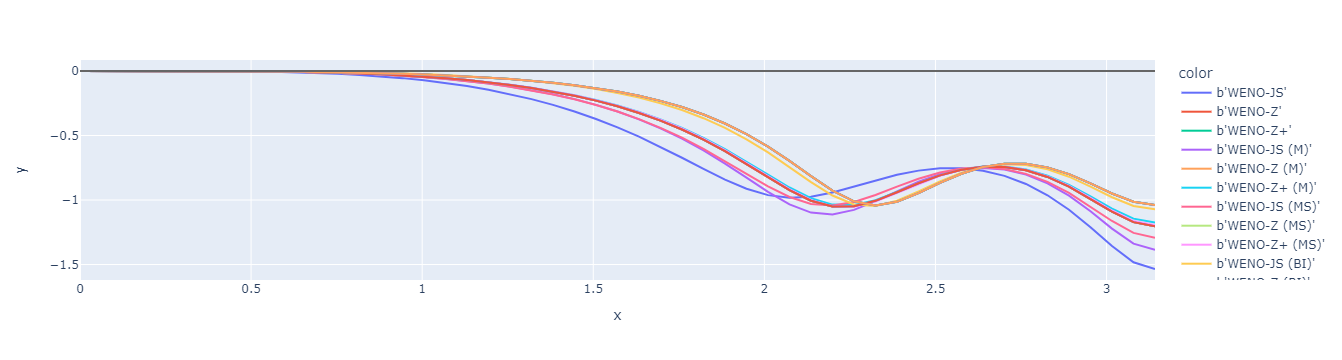

In [56]:
fig = ply_exp.line(
    data_frame = df    ,
    x          = x     ,
    y          = y     ,
    color      = label
)
fig.add_trace(
    ply_go.Scatter(
        x    = 2*np.pi*np.arange(int(N/2)+1)/N,
        y    = 0*np.arange(int(N/2)+1),
        mode = "lines"                                           ,
        line = ply_go.scatter.Line(color="#666666")              ,
        name = "Referência"
    )
)
fig.show()

In [57]:
fig.write_html("C:/Users/daniw/OneDrive/Documentos/GitHub/Top_mat_A/WENO-BI/teste_ADR_imag (N=100, tau=10^(-2)).html")